# GAN on C2C ski touring outing data

In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, losses, optimizers, metrics, regularizers
import tensorview as tv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from plotly import express as px, graph_objects as go, subplots as sp
import itertools

In [2]:
area_title = 'haute-savoie'

In [3]:
df_outings = pd.read_parquet(f'data/C2C/outings_{area_title}.parquet')

In [35]:
used_cols = ['ski_rating_num', 'elevation_max', 'elevation_up_snow', 'elevation_down_snow', 'condition_rating_num', 
             'TEMPERATURE_MORNING_C', 'temp_morning_7d', 'temp_morning_30d', 'day_of_season'] 
#, 'season']

condition = (df_outings.elevation_up_snow < 5000) & (df_outings.elevation_down_snow < 5000) & (df_outings.elevation_max < 5000) \
                & (df_outings.elevation_up_snow > 200) & (df_outings.elevation_down_snow > 200) & (df_outings.elevation_max > 200) \
               & ((df_outings.quality == 'fine') | (df_outings.quality == 'medium') | (df_outings.quality == 'great'))

df_sel = df_outings.loc[condition, used_cols]
df_sel = df_sel[(~df_sel.isna().any(axis=1))]
len(df_sel)

6656

In [5]:
scaler = StandardScaler()
df_sel_scaled = scaler.fit_transform(df_sel)

## Model

In [6]:
batch_size = 512
latent_dim = 30
num_features = len(used_cols)

In [7]:
disc_learning_rate = 0.002
gen_learning_rate  = 0.003

relu_alpha = 0.001

In [8]:
generator = models.Sequential([
    layers.Dense(32, input_dim=latent_dim, name='g_1'),
    layers.LeakyReLU(relu_alpha),
    layers.Dropout(0.3),
    layers.Dense(48, name='g_2'),
    layers.LeakyReLU(relu_alpha),
    layers.Dropout(0.2),
    layers.Dense(48, name='g_3'),
    layers.LeakyReLU(relu_alpha),
    layers.Dense(64, name='g_4'),
    layers.LeakyReLU(relu_alpha),
    layers.Dropout(0.2),
    layers.Dense(num_features, name='g_5')
], name='generator')

In [9]:
discriminator = models.Sequential([
    layers.Dense(64, input_dim=num_features, name='d_1'),
    layers.LeakyReLU(relu_alpha),
    layers.Dropout(0.3),
    layers.Dense(48, name='d_2'),
    layers.LeakyReLU(relu_alpha),
    layers.Dropout(0.2),
    layers.Dense(48, name='d_3'),
    layers.LeakyReLU(relu_alpha),
    layers.Dense(32, name='d_4'),
    layers.LeakyReLU(relu_alpha),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid', name='d_5')
], name='discriminator')

In [10]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, lr):
        super(CustomSchedule, self).__init__()
        self.lr = lr

    def __call__(self, step):
        return self.lr / tf.math.log(step / 10 + 2)

In [11]:
discriminator.compile(optimizer=optimizers.RMSprop(CustomSchedule(disc_learning_rate)), # Adam
                loss=losses.binary_crossentropy,
                metrics=['accuracy'])
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d_1 (Dense)                  (None, 64)                640       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
d_2 (Dense)                  (None, 48)                3120      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 48)                0         
_________________________________________________________________
d_3 (Dense)                  (None, 48)                2352      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 48)              

In [12]:
# Stack the generator and discriminator in order to train the generator
# Do not train the discriminator along with the generator
discriminator.trainable = False 
combined = models.Sequential([generator, discriminator])
combined.compile(optimizer=optimizers.RMSprop(CustomSchedule(gen_learning_rate)), # Adam
              loss=losses.binary_crossentropy,
              metrics=['accuracy'])
combined.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 9)                 8649      
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 7713      
Total params: 16,362
Trainable params: 8,649
Non-trainable params: 7,713
_________________________________________________________________


## Train

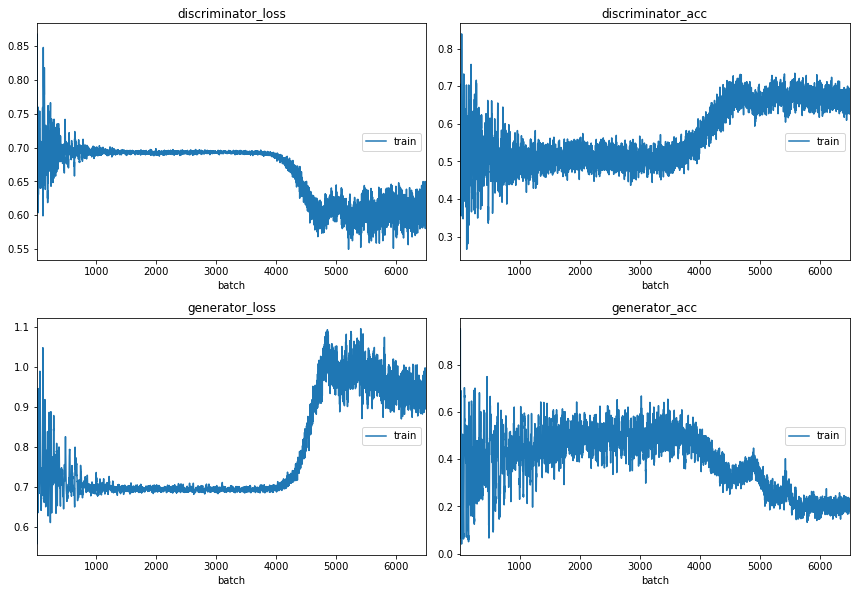

In [13]:
epochs = 500

batch_per_epoch = len(df_sel_scaled)//batch_size

# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

tv_plot = tv.train.PlotMetrics(wait_num=50, columns=2, iter_num=epochs * batch_per_epoch)

for epoch in range(epochs):

    for b in range(batch_per_epoch):

        train_batch = df_sel_scaled[b * batch_size:(b+1) * batch_size]
        
        # Discriminator

        # Sample noise and generate a batch of new outings
        gen_latent = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_outings = generator.predict(gen_latent)

        # Train the discriminator (real classified as true and generated as false)
        d_loss, d_acc = discriminator.train_on_batch(np.vstack((train_batch, gen_outings)), 
                                                     np.vstack((valid, fake)), 
                                                    reset_metrics=True)
        
        # Generator

        # Train the generator (wants discriminator to take fake outings as true)
        g_loss, g_acc = combined.train_on_batch(gen_latent, 
                                                 valid, 
                                                 reset_metrics=True)
        
        # Plot
        tv_plot.update({'discriminator_loss': d_loss, 'discriminator_acc': d_acc,
                        'generator_loss': g_loss, 'generator_acc': g_acc})
        tv_plot.draw()

## Test

In [14]:
gen_latent = np.random.normal(0, 1, (5000, latent_dim))
gen_outings = generator.predict(gen_latent)
gen_outings_unscaled = scaler.inverse_transform(gen_outings)

In [15]:
df_generated = pd.DataFrame(gen_outings_unscaled, columns=used_cols)

In [16]:
df_generated.head()

ski_rating_num  elevation_max  elevation_up_snow  elevation_down_snow  \
0        3.198679    2435.512207        1081.458862          1098.472168   
1        4.925803    2043.089844        1169.189453          1202.252075   
2        6.818957    1601.576782         749.664429           966.250305   
3        7.768322    2456.746582        1136.342163          1119.626831   
4        5.512092    2557.058594        1268.221069          1273.059204   

   condition_rating_num  TEMPERATURE_MORNING_C  temp_morning_7d  \
0              3.003207              -3.835163        -4.693306   
1              3.005034              -7.518096        -4.342985   
2              4.061568             -14.654158        -6.865903   
3              2.997456             -10.939281        -9.234188   
4              3.019841              -0.982283         0.580688   

   temp_morning_30d  day_of_season  
0         -5.599360      43.160656  
1         -3.154439       5.541389  
2         -4.701797      10.136519  
3         -8.195723      40.224670  
4         -1.296922      43.310131

Elevation [m]


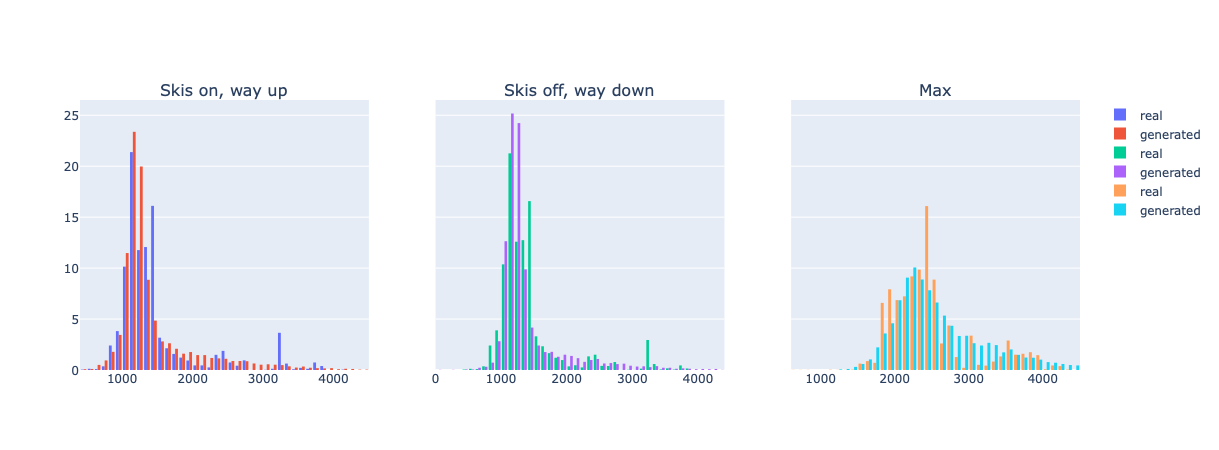

In [17]:
print('Elevation [m]')
fig = sp.make_subplots(rows=1, cols=3, shared_yaxes=True, subplot_titles=['Skis on, way up', 'Skis off, way down', 'Max'])
bins = {'start': 0, 'end': 4500, 'size': 100}
fig.add_trace(go.Histogram(x=df_sel['elevation_up_snow'], xbins=bins, name='real', histnorm='percent'), row=1, col=1)
fig.add_trace(go.Histogram(x=df_generated['elevation_up_snow'], xbins=bins, name='generated', histnorm='percent'), row=1, col=1)
fig.add_trace(go.Histogram(x=df_sel['elevation_down_snow'], xbins=bins, name='real', histnorm='percent'), row=1, col=2)
fig.add_trace(go.Histogram(x=df_generated['elevation_down_snow'], xbins=bins, name='generated', histnorm='percent'), row=1, col=2)
fig.add_trace(go.Histogram(x=df_sel['elevation_max'], xbins=bins, name='real', histnorm='percent'), row=1, col=3)
fig.add_trace(go.Histogram(x=df_generated['elevation_max'], xbins=bins, name='generated', histnorm='percent'), row=1, col=3)

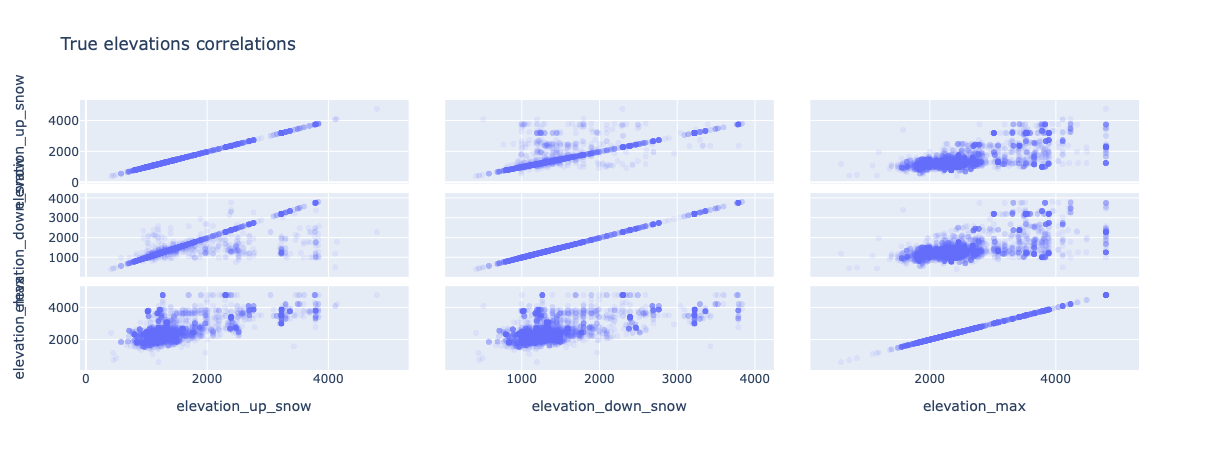

In [18]:
px.scatter_matrix(df_sel[['elevation_up_snow', 'elevation_down_snow', 'elevation_max']], opacity=0.1, title='True elevations correlations')

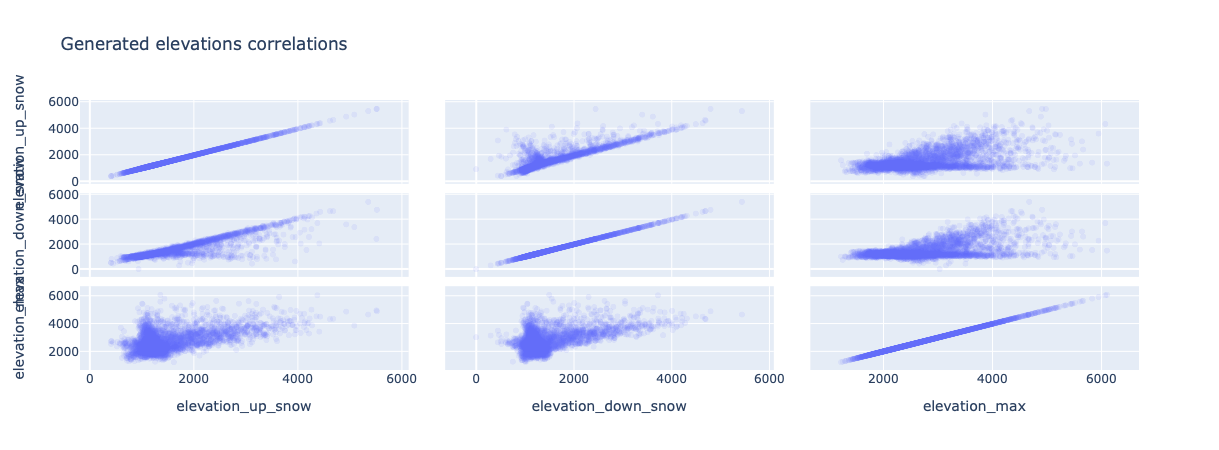

In [19]:
px.scatter_matrix(df_generated[['elevation_up_snow', 'elevation_down_snow', 'elevation_max']], opacity=0.1, title='Generated elevations correlations')

Mean/std day of season, for true=7.71/46.9, for generated=25.4/40.5


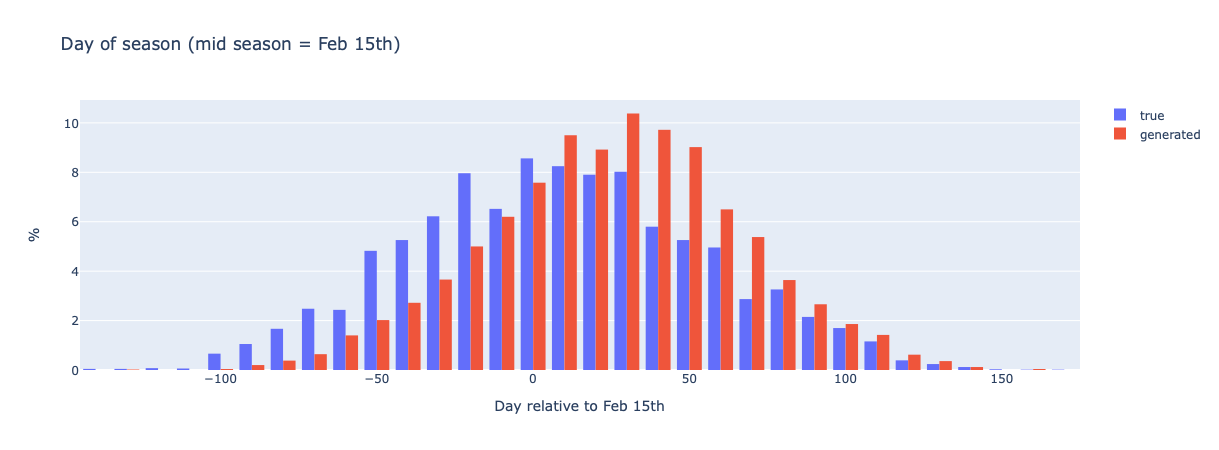

In [20]:
print(f'Mean/std day of season, for true={df_sel.day_of_season.mean():.3g}/{df_sel.day_of_season.std():.3g}, for generated={df_generated.day_of_season.mean():.3g}/{df_generated.day_of_season.std():.3g}')

fig = go.Figure(layout=dict(title='Day of season (mid season = Feb 15th)', bargroupgap=0.01, 
                            xaxis=dict(title='Day relative to Feb 15th'), yaxis=dict(title='%')))
fig.add_histogram(x=df_sel.day_of_season, name='true', nbinsx=52, histnorm='percent')
fig.add_histogram(x=df_generated.day_of_season, name='generated', nbinsx=52, histnorm='percent')

In [43]:
ski_rating_unmapper = {**{3*i + j: f'{i+1}.{j+1}' for i,j in itertools.product(range(5), range (3))}, 15: '5.4', 16: '5.5', 17: '5.6'}
df_generated['ski_rating'] = df_generated['ski_rating_num'].round().clip(0, 17).replace(ski_rating_unmapper)

Mean/std ski rating num, for true=6.38/3.07, for generated=6.15/2.92


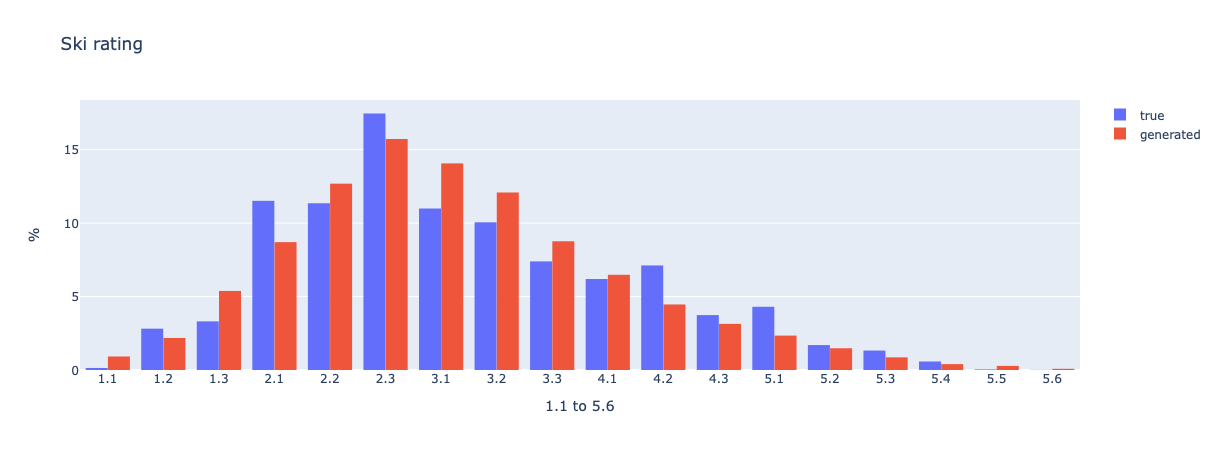

In [45]:
print(f'Mean/std ski rating num, for true={df_sel.ski_rating_num.mean():.3g}/{df_sel.ski_rating_num.std():.3g}, for generated={df_generated.ski_rating_num.mean():.3g}/{df_generated.ski_rating_num.std():.3g}')
fig = go.Figure(layout=dict(title='Ski rating', bargroupgap=0.01, 
                            xaxis=dict(title='1.1 (easy) to 5.6 (extreme)', categoryorder='array', categoryarray=list(ski_rating_unmapper.values()), type="category"), yaxis=dict(title='%')))
fig.add_histogram(x=df_outings[condition].ski_rating, name='true', histnorm='percent')
fig.add_histogram(x=df_generated.ski_rating, name='generated', histnorm='percent')

Mean/std morning temperature, for true=-5.31/6.7, for generated=-4.88/6.81


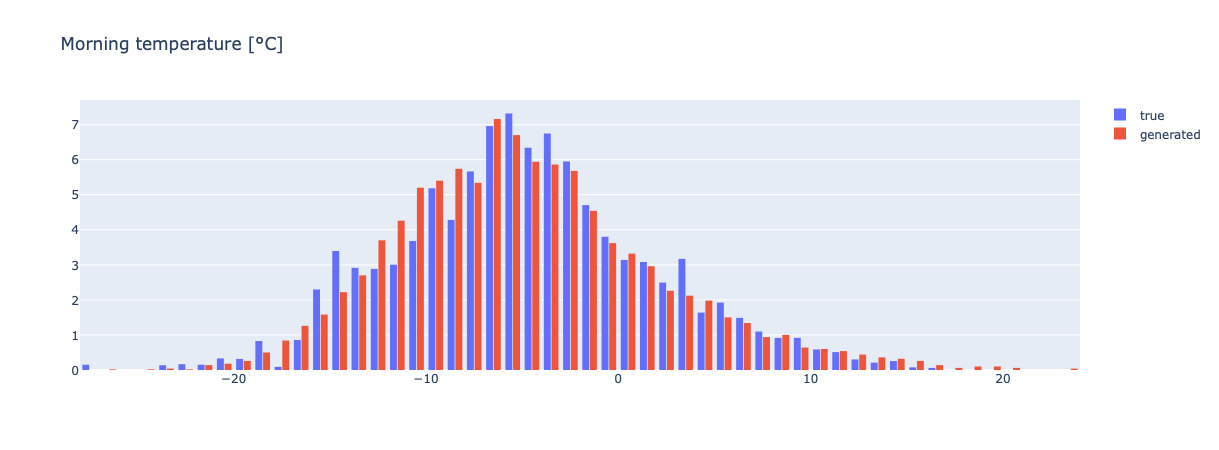

In [22]:
print(f'Mean/std morning temperature, for true={df_sel.TEMPERATURE_MORNING_C.mean():.3g}/{df_sel.TEMPERATURE_MORNING_C.std():.3g}, for generated={df_generated.TEMPERATURE_MORNING_C.mean():.3g}/{df_generated.TEMPERATURE_MORNING_C.std():.3g}')
fig = go.Figure(layout=dict(title='Morning temperature [°C]', bargroupgap=0.1))
bins = {'start': -35, 'end': 30, 'size': 1}
fig.add_histogram(x=df_sel.TEMPERATURE_MORNING_C, name='true', histnorm='percent', xbins=bins)
fig.add_histogram(x=df_generated.TEMPERATURE_MORNING_C, name='generated', histnorm='percent', xbins=bins)

Mean/std 7 day morning temperature, for true=-4.79/5.38, for generated=-4.16/5.56


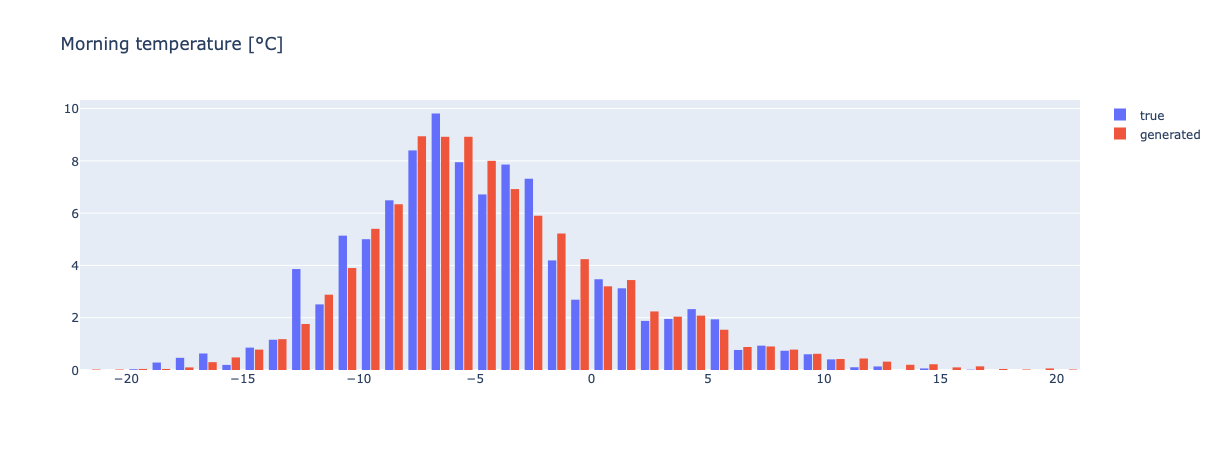

In [24]:
print(f'Mean/std 7 day morning temperature, for true={df_sel.temp_morning_7d.mean():.3g}/{df_sel.temp_morning_7d.std():.3g}, for generated={df_generated.temp_morning_7d.mean():.3g}/{df_generated.temp_morning_7d.std():.3g}')
fig = go.Figure(layout=dict(title='Morning temperature [°C]', bargroupgap=0.1))
bins = {'start': -35, 'end': 30, 'size': 1}
fig.add_histogram(x=df_sel.temp_morning_7d, name='true', histnorm='percent', xbins=bins)
fig.add_histogram(x=df_generated.temp_morning_7d, name='generated', histnorm='percent', xbins=bins)

Mean/std 30 day morning temperature, for true=-4.72/4.23, for generated=-4.2/4.48


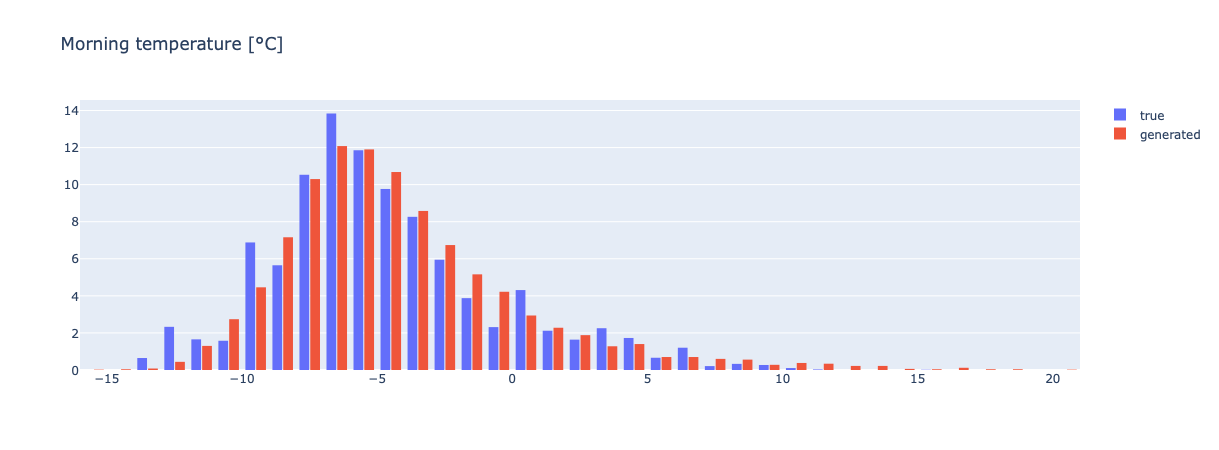

In [25]:
print(f'Mean/std 30 day morning temperature, for true={df_sel.temp_morning_30d.mean():.3g}/{df_sel.temp_morning_30d.std():.3g}, for generated={df_generated.temp_morning_30d.mean():.3g}/{df_generated.temp_morning_30d.std():.3g}')
fig = go.Figure(layout=dict(title='Morning temperature [°C]', bargroupgap=0.1))
bins = {'start': -35, 'end': 30, 'size': 1}
fig.add_histogram(x=df_sel.temp_morning_30d, name='true', histnorm='percent', xbins=bins)
fig.add_histogram(x=df_generated.temp_morning_30d, name='generated', histnorm='percent', xbins=bins)